In [1]:
import mitsuba as mi

mi.set_variant("cuda_ad_rgb")
import drjit as dr
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

import os
import sys
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from utils.rough_scene import (
    ENVLIGHT_KEY,
    ROUGH_KEY,
    Scene,
    generate_rand_envlight,
    generate_rand_init_values,
    generate_rand_rough_tex,
    plot_rough_envlight,
    plot_rough_envlight2,
    reset_scene,
    reset_func,
    get_full_zeros_params,
    get_full_ones_params,
    run_opt_set_init,
    plot_opt_results,
)
from utils.utils import image_to_bm, to_float, unidim_to_bm, rel_l1_loss, mse, LOSS_FNS
from utils.plot import (
    plot_loss_linear_interp_1d,
    plot_loss_bilinear_interp_2d,
    plot_losses,
)

mi.Thread.thread().logger().set_log_level(mi.LogLevel.Error)

# Reference scenes rendering

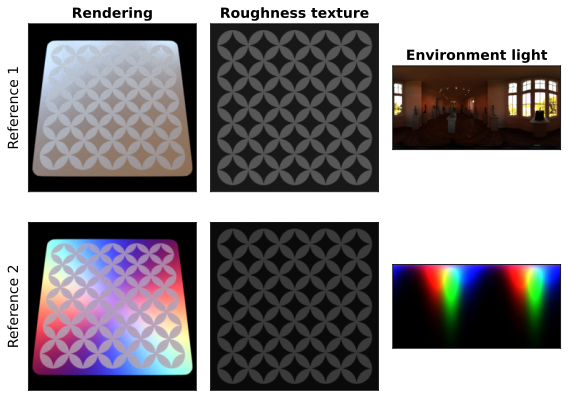

In [2]:
scene_ref = {k: reset_scene(k) for k in Scene}
params = {k: mi.traverse(scene_ref[k]) for k in Scene}

# Render reference images
image_ref = {k: mi.render(scene_ref[k], seed=0, spp=128) for k in Scene}
params_rough_ref = {k: params[k][ROUGH_KEY] for k in Scene}
params_envlight_ref = {k: params[k][ENVLIGHT_KEY] for k in Scene}

image_ref_bm = {k: image_to_bm(image_ref[k])  for k in Scene}
params_rough_ref_bm = {k: unidim_to_bm(params_rough_ref[k])  for k in Scene}
params_envlight_ref_bm = {k: unidim_to_bm(params_envlight_ref[k])  for k in Scene}

refs = {k: {
    "img": image_ref_bm[k],
    "params_rough": params_rough_ref_bm[k],
    "params_envlight": params_envlight_ref_bm[k],
} for k in Scene}

def get_ref_params(scene_id):
    return {
        ROUGH_KEY: params_rough_ref[scene_id],
        ENVLIGHT_KEY: params_envlight_ref[scene_id],
    }

# Plot
plot_rough_envlight2({f'Reference {k.value}': (image_ref_bm[k], params_rough_ref_bm[k], params_envlight_ref_bm[k]) for k in Scene})

In [3]:
nb_samples = 2
spp_primal = 32
spp_grad = 4

In [4]:
# get reference losses
scene_s1 = reset_scene(Scene.COND1)
image_s1 = mi.render(scene_s1, mi.traverse(scene_s1), seed=0, spp=spp_primal, spp_grad=spp_grad)
ref_loss_s1 = {k: to_float(LOSS_FNS[k](image_s1, image_ref[Scene.COND1])) for k in LOSS_FNS}

scene_s2 = reset_scene(Scene.COND2)
image_s2 = mi.render(scene_s2, mi.traverse(scene_s2), seed=0, spp=spp_primal, spp_grad=spp_grad)
ref_loss_s2 = {k: to_float(LOSS_FNS[k](image_s2, image_ref[Scene.COND2])) for k in LOSS_FNS}

# Scene 1 + Adam + Relative L1 loss + rand init

In [5]:
init_values_s1_adam_l1 = [
    generate_rand_init_values(Scene.COND1, seed=i) for i in range(nb_samples)
]
res_s1_adam_l1 = run_opt_set_init(
    image_ref[Scene.COND1],
    init_values_s1_adam_l1,
    reset_func[Scene.COND1],
    n_iterations=200,
    optimizer_name="adam",
    lr=1e-2,
    loss_fn=rel_l1_loss,
    spp_primal=spp_primal,
    spp_grad=spp_grad,
)

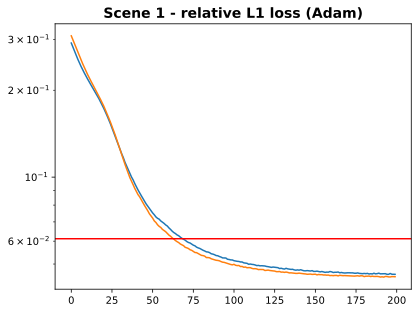

In [6]:
plot_losses(res_s1_adam_l1["losses"], baseline=ref_loss_s1["Relative L1"], title="Scene 1 - relative L1 loss (Adam)")

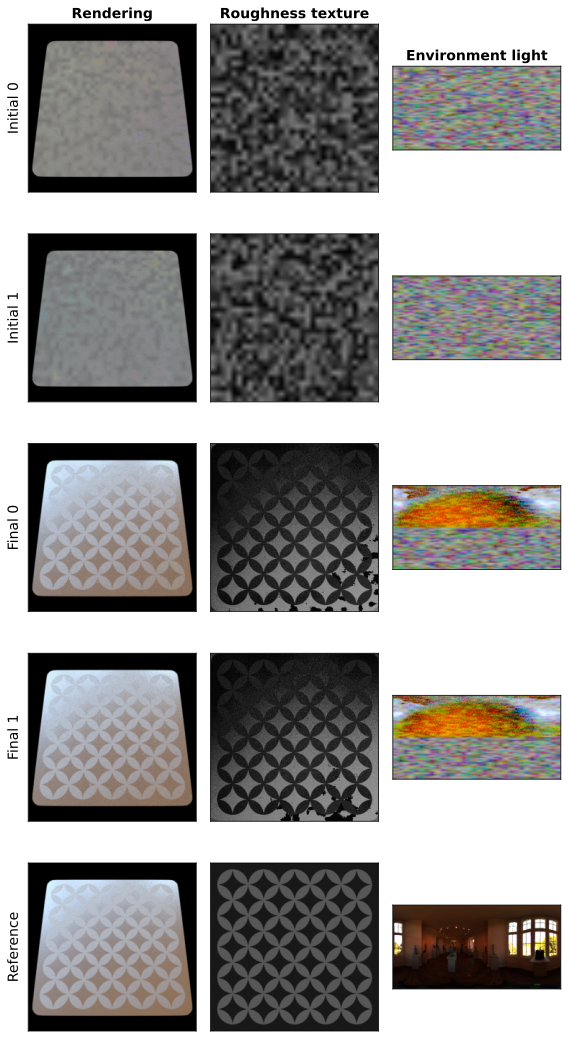

In [7]:
plot_opt_results(res_s1_adam_l1, refs[Scene.COND1], nb_results=nb_samples, size_factor=3)

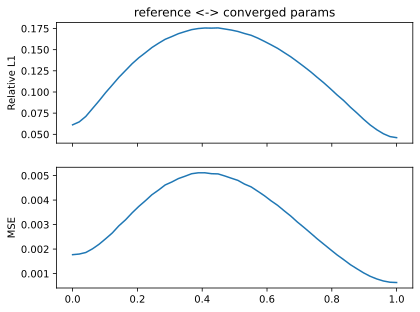

In [8]:
params_1 = get_ref_params(Scene.COND1)
params_2 = res_s1_adam_l1["params_end"][0]
plot_loss_linear_interp_1d(image_ref[Scene.COND1], params_1, params_2, reset_func[Scene.COND1], title="reference <-> converged params")

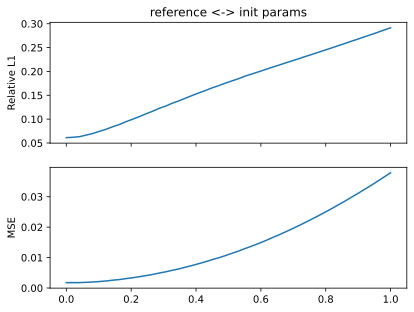

In [9]:
params_1 = get_ref_params(Scene.COND1)
params_2 = init_values_s1_adam_l1[0]
plot_loss_linear_interp_1d(image_ref[Scene.COND1], params_1, params_2, reset_func[Scene.COND1], title="reference <-> init params")

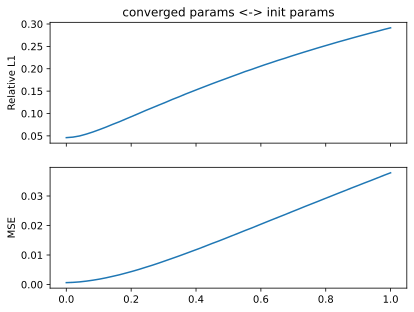

In [10]:
params_1 = res_s1_adam_l1["params_end"][0]
params_2 = init_values_s1_adam_l1[0]
plot_loss_linear_interp_1d(image_ref[Scene.COND1], params_1, params_2, reset_func[Scene.COND1], title="converged params <-> init params")

# Scene 2 + Adam + relative L1 loss + rand init

In [11]:
init_values_s2_adam_l1 = [
    generate_rand_init_values(Scene.COND2, seed=i) for i in range(nb_samples)
]
res_s2_adam_l1 = run_opt_set_init(
    image_ref[Scene.COND2],
    init_values_s2_adam_l1,
    reset_func[Scene.COND2],
    n_iterations=200,
    optimizer_name="adam",
    lr=2e-2,
    loss_fn=rel_l1_loss,
    spp_primal=spp_primal,
    spp_grad=spp_grad,
)

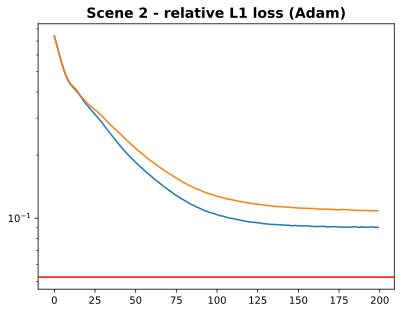

In [12]:
plot_losses(res_s2_adam_l1["losses"], baseline=ref_loss_s2["Relative L1"], title="Scene 2 - relative L1 loss (Adam)")

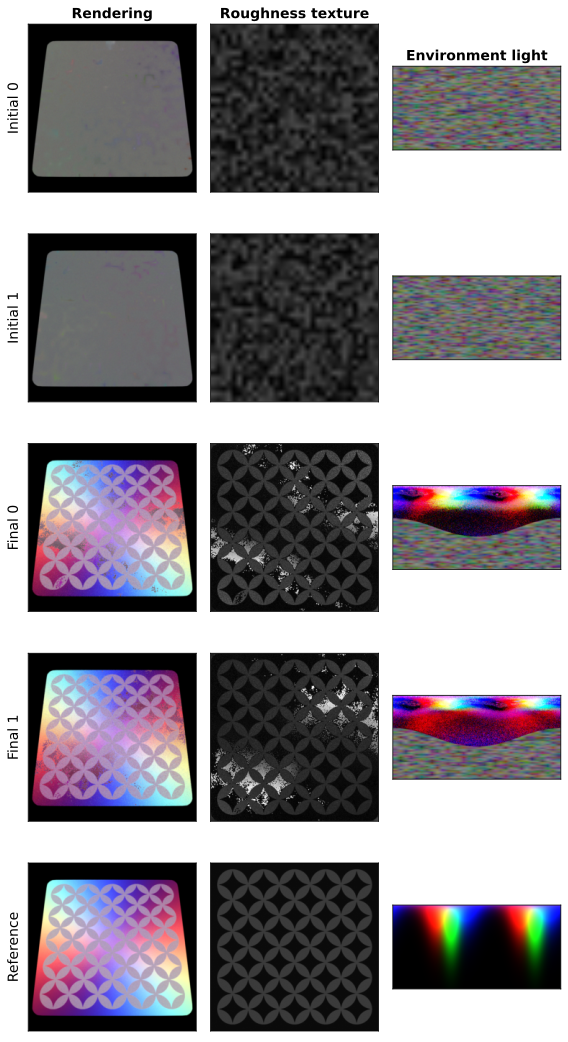

In [13]:
plot_opt_results(res_s2_adam_l1, refs[Scene.COND2], nb_results=nb_samples, size_factor=3)

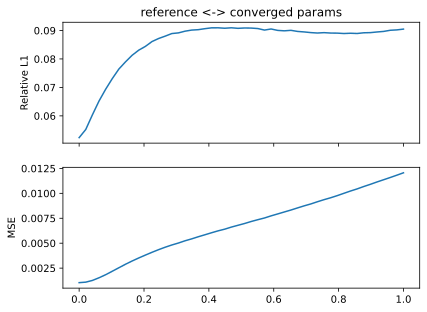

In [14]:
params_1 = get_ref_params(Scene.COND2)
params_2 = res_s2_adam_l1["params_end"][0]
plot_loss_linear_interp_1d(image_ref[Scene.COND2], params_1, params_2, reset_func[Scene.COND2], title="reference <-> converged params")

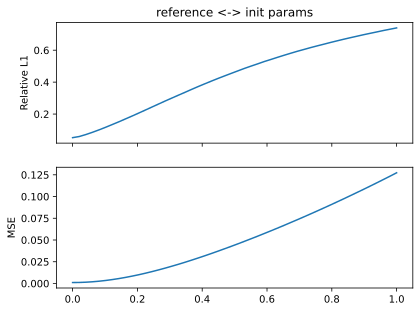

In [15]:
params_1 = get_ref_params(Scene.COND2)
params_2 = init_values_s2_adam_l1[0]
plot_loss_linear_interp_1d(image_ref[Scene.COND2], params_1, params_2, reset_func[Scene.COND2], title="reference <-> init params")

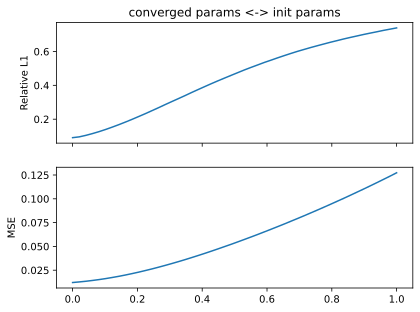

In [16]:
params_1 = res_s2_adam_l1["params_end"][0]
params_2 = init_values_s2_adam_l1[0]
plot_loss_linear_interp_1d(image_ref[Scene.COND2], params_1, params_2, reset_func[Scene.COND2], title="converged params <-> init params")

# Scene 2 + Adam + relative L1 loss + rand init roughness tex + one init envlight

In [17]:
init_values_s2_adam_l1_ones = [
    {
        ROUGH_KEY: generate_rand_rough_tex(Scene.COND2, seed=123),
        ENVLIGHT_KEY: get_full_ones_params()[ENVLIGHT_KEY],
    }
]
res_s2_adam_l1_ones = run_opt_set_init(
    image_ref[Scene.COND2],
    init_values_s2_adam_l1_ones,
    reset_func[Scene.COND2],
    n_iterations=200,
    optimizer_name="adam",
    lr=2e-2,
    loss_fn=rel_l1_loss,
    spp_primal=spp_primal,
    spp_grad=spp_grad,
)

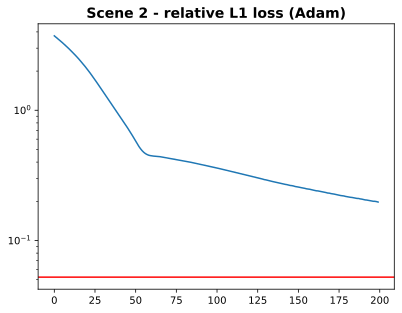

In [18]:
plot_losses(res_s2_adam_l1_ones["losses"], baseline=ref_loss_s2["Relative L1"], title="Scene 2 - relative L1 loss (Adam)")

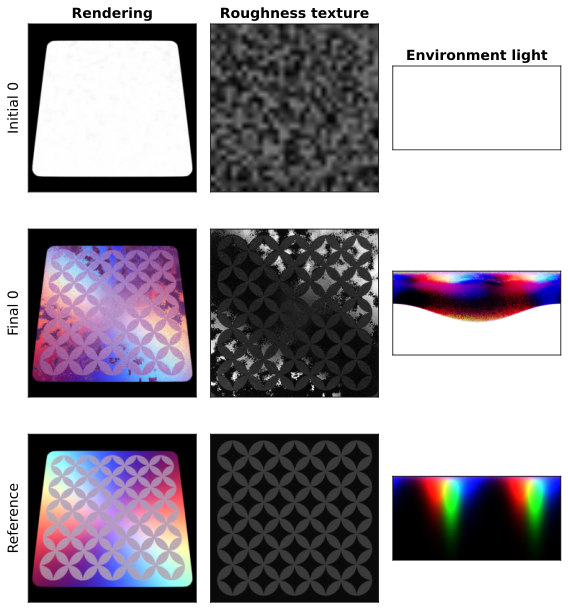

In [19]:
plot_opt_results(res_s2_adam_l1_ones, refs[Scene.COND2], nb_results=1, size_factor=3)

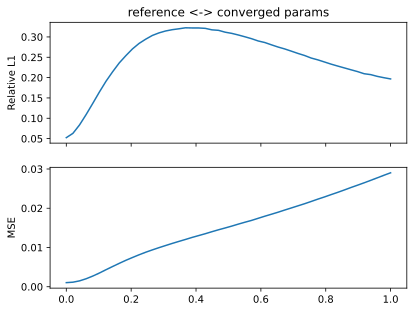

In [20]:
params_1 = get_ref_params(Scene.COND2)
params_2 = res_s2_adam_l1_ones["params_end"][0]
plot_loss_linear_interp_1d(image_ref[Scene.COND2], params_1, params_2, reset_func[Scene.COND2], title="reference <-> converged params")

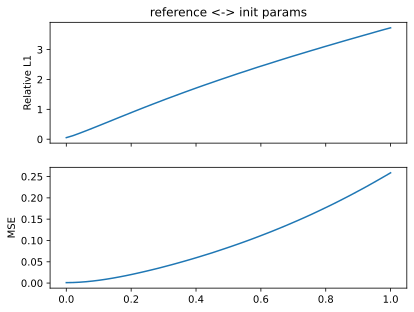

In [21]:
params_1 = get_ref_params(Scene.COND2)
params_2 = init_values_s2_adam_l1_ones[0]
plot_loss_linear_interp_1d(image_ref[Scene.COND2], params_1, params_2, reset_func[Scene.COND2], title="reference <-> init params")

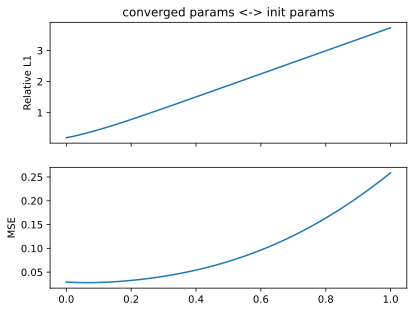

In [22]:
params_1 = res_s2_adam_l1_ones["params_end"][0]
params_2 = init_values_s2_adam_l1_ones[0]
plot_loss_linear_interp_1d(image_ref[Scene.COND2], params_1, params_2, reset_func[Scene.COND2], title="converged params <-> init params")

# Scene 2 + Adam + relative L1 loss + rand init roughness tex + zeros init envlight

In [29]:
init_values_s2_adam_l1_zeros = [
    {
        ROUGH_KEY: generate_rand_rough_tex(Scene.COND2, seed=123),
        ENVLIGHT_KEY: get_full_zeros_params()[ENVLIGHT_KEY],
    }
]
res_s2_adam_l1_zeros = run_opt_set_init(
    image_ref[Scene.COND2],
    init_values_s2_adam_l1_zeros,
    reset_func[Scene.COND2],
    n_iterations=200,
    optimizer_name="adam",
    lr=2e-2,
    loss_fn=rel_l1_loss,
    spp_primal=spp_primal,
    spp_grad=spp_grad,
)

KeyboardInterrupt: 

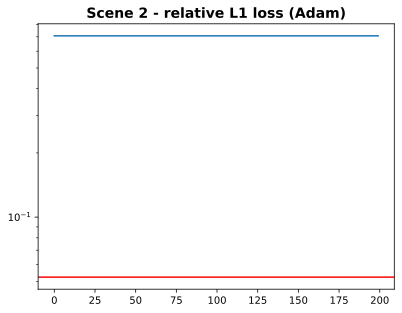

In [24]:
plot_losses(res_s2_adam_l1_zeros["losses"], baseline=ref_loss_s2["Relative L1"], title="Scene 2 - relative L1 loss (Adam)")

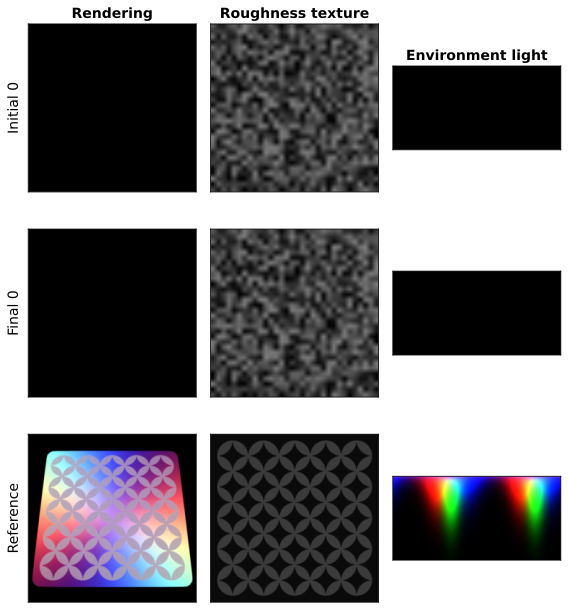

In [25]:
plot_opt_results(res_s2_adam_l1_zeros, refs[Scene.COND2], nb_results=1, size_factor=3)

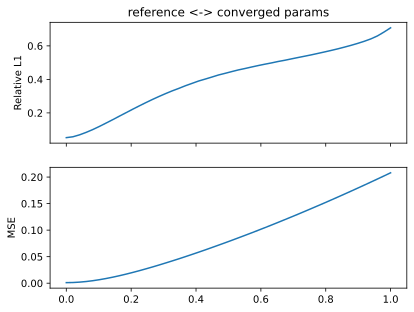

In [26]:
params_1 = get_ref_params(Scene.COND2)
params_2 = res_s2_adam_l1_zeros["params_end"][0]
plot_loss_linear_interp_1d(image_ref[Scene.COND2], params_1, params_2, reset_func[Scene.COND2], title="reference <-> converged params")

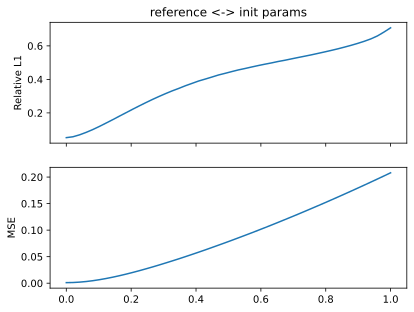

In [27]:
params_1 = get_ref_params(Scene.COND2)
params_2 = init_values_s2_adam_l1_zeros[0]
plot_loss_linear_interp_1d(image_ref[Scene.COND2], params_1, params_2, reset_func[Scene.COND2], title="reference <-> init params")

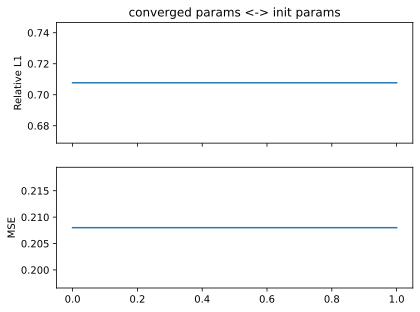

In [28]:
params_1 = res_s2_adam_l1_zeros["params_end"][0]
params_2 = init_values_s2_adam_l1_zeros[0]
plot_loss_linear_interp_1d(image_ref[Scene.COND2], params_1, params_2, reset_func[Scene.COND2], title="converged params <-> init params")